# EIS test measurments

### Importing

In [1]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from importlib import reload
import pandas as pd
import time
from scipy.fft import fft, fftfreq
import os

import src.Keysight_DAQ360A_pyvisa
import src.SDG_pyvisa

reload(src.Keysight_DAQ360A_pyvisa)
reload(src.SDG_pyvisa)

from src.Keysight_DAQ360A_pyvisa import Keysight_DAQ370A
from src.SDG_pyvisa import SDG

### Functions

In [2]:
def current_2_p2p_voltage(current_rms, volt_curr_transfer):
    current_p2p = current_rms*np.sqrt(2)*2
    voltage_p2p = volt_curr_transfer[0]/volt_curr_transfer[1]*current_p2p
    return voltage_p2p

def fft_sine(t, y):
    N = len(t)
    dt = t[1] - t[0]
    freq = fftfreq(N, dt)
    Y = fft(y.values-np.mean(y.values))
    
    # Consider only positive frequencies
    positive_idx = np.where(freq > 0)
    Y_positive = Y[positive_idx]
    freq_positive = freq[positive_idx]
    
    # Find the dominant frequency component
    idx = np.argmax(np.abs(Y_positive))
    f_est = freq_positive[idx]
    A_est = (2 * np.abs(Y_positive[idx])) / N
    phi_est = np.angle(Y_positive[idx])
    C_est = np.mean(y)
    phase_deg = (phi_est / (2 * np.pi)) * 360 % 360
    
    # Add ALIGNED flag if desired (for example, checking if phase is within a tolerance)
    # Here we use a dummy condition; modify as needed for your application.
    aligned = "YES" if abs(phase_deg - 45) < 10 else "NO"
    
    result = pd.Series({
        'Amplitude': A_est,
        'Frequency': f_est,
        'Phase': phase_deg,
        'Offset': C_est,
        'ALIGNED': aligned
    })
    
    return result

def create_df_with_prefix(series1, series2, prefix1, prefix2):
    """
    Combine two Series with prefixes into one row DataFrame
    """
    # Rename series with prefix
    series1 = series1.add_prefix(f"{prefix1}_")
    series2 = series2.add_prefix(f"{prefix2}_")

    # Merge both series into one row DataFrame
    return pd.concat([series1, series2]).to_frame().T

def import_csv_folder(folder_path):
    csv_dict = {}
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            name = os.path.splitext(filename)[0]
            csv_dict[name] = pd.read_csv(os.path.join(folder_path, filename))
    return csv_dict

def plot_frequency_subplots(freq_dict):
    num_freqs = len(freq_dict)
    fig, axs = plt.subplots(num_freqs, 1, figsize=(12, 4 * num_freqs), sharex=False)
    
    if num_freqs == 1:
        axs = [axs]  # Make sure axs is iterable if only one frequency
    
    for i, (freq, df) in enumerate(freq_dict.items()):
        ax1 = axs[i]
        ax2 = ax1.twinx()
        
        # Plot Voltage over Time (left axis)
        ax1.plot(df['Time'], df['Voltage'], color='b', label=f'Voltage @ {freq} Hz')
        ax1.set_ylabel('Voltage (V)')
        ax1.set_title(f'Voltage and Current over Time @ {freq} Hz')
        ax1.grid(True)
        ax1.legend(loc='upper left')
        
        # Plot Current over Time (right axis)
        ax2.plot(df['Time'], df['Current'], color='r', label=f'Current @ {freq} Hz')
        ax2.set_ylabel('Current (A)')
        ax2.legend(loc='upper right')
        
        ax1.set_xlabel('Time (s)')

    plt.tight_layout()
    plt.show()

def plot_nyquist(ax, data, label, title):

    ax.plot(data.Impedance_real*1000, data.Impedance_imag*1000, '.-', label=label)
    plot_preferences(ax, xlabel = 'Re [mOhm]', ylabel = 'Im [mOhm]', title = title, legend=True)

def plot_bode_re_imag(ax,data, label, title):

    ax[0].plot(data.Frequency, data.Impedance_real*1000, '.-', label=label)
    ax[1].plot(data.Frequency, data.Impedance_imag*1000,'.-', label=label) 
    ax[2].plot(data.Frequency, data.Impedance_imag/(2*np.pi*data.Frequency)*1000000000, '.-', label=label) 

    plot_preferences(ax[0], xlabel = '', ylabel = 'Real [mOhm]', title=title, legend=True)
    plot_preferences(ax[1], xlabel = '', ylabel = 'Imag [mOhm]', legend=True)
    plot_preferences(ax[2], xlabel = 'Frequency [Hz]', ylabel = 'Inductance [nH]', legend=True)

def plot_bode(ax,data, label, title):

    ax[0].plot(data.Frequency, data.Impedance_real*1000, '.-', label=label)
    ax[1].plot(data.Frequency, data.Impedance_imag*1000,'.-', label=label) 

    plot_preferences(ax[0], xlabel = '', ylabel = 'Amplitude [mOhm]', title=title, legend=False)
    plot_preferences(ax[1], xlabel = '', ylabel = 'Phase [deg]', legend=False)

def plot_preferences(axs, xlabel = '', ylabel = '', title = '', legend = False):
        
        axs.set_xlabel(xlabel)
        axs.set_ylabel(ylabel)
        if legend: axs.legend()
        axs.grid()

        axs.set_title(title, fontweight="bold")

        axs.minorticks_on()
        axs.grid(which='minor', linewidth = 0.5, linestyle='dotted')
        axs.grid(which='major', linewidth = 0.5, linestyle='-')

### Constatns

In [48]:
impedance_name = '2mOhm_gen2_PowerCo_5'
folder = 'Impedance_data_gen2_powerCo_fixture'

### Initialize instruments

In [17]:
func_gen= SDG(adress='USB0::0xF4EC::0x1102::SDG2XCAD4R3801::0::INSTR')
func_gen.initialize(timeout=4000, channel=1, frequency=100, voltage_amp_p2p=0.2)#0.001

daq = Keysight_DAQ370A(adress='USB0::0x2A8D::0x5101::MY58021228::INSTR')
daq.instrument.timeout = 116000
daq.identification()

'Keysight Technologies,DAQ970A,MY58021228,A.02.02-01.00-02.01-00.02-02.00-03-02\n'

### Performing measurments

In [ ]:
config_df =pd.read_excel('config_cal.xlsx')

meas_data_dict = {}

shunt_value = 0.008

first = True
for config in config_df.itertuples(index=True):

    daq.set_channel_acquire3(channel=101, range=config.Ch1_range, type='DIFF', coupling='AC', mode='TIME', samp_count=config.Samp_count, samp_rate=config.Samp_rate)
    daq.set_channel_acquire3(channel=102, range=config.Ch2_range, type='DIFF', coupling='AC', mode='TIME', samp_count=config.Samp_count, samp_rate=config.Samp_rate)

    time.sleep(1)
    
    func_gen.set_frequency(channel=1, frequency=config.Frequency)
    amplitude = current_2_p2p_voltage(config.Current_rms, [1,100])
    func_gen.set_amplitude_p2p(channel=1, amplitude=amplitude)

    time.sleep(3)

    if first:
        first=False
        time.sleep(5)

    if config.Frequency>5000:
        time.sleep(5)

    daq.init3(channel_1=101, channel_2=102)

    meas_data_ch1 = daq.fetch3(channel=101, sample_rate=config.Samp_rate)
    meas_data_ch2 = daq.fetch3(channel=102, sample_rate=config.Samp_rate)
    
    meas_data = meas_data_ch2
    meas_data['Current'] = meas_data_ch1['Voltage']/shunt_value
    
    meas_data_dict[config.Frequency] = meas_data

### Sine FFT

In [50]:
all_results = []

for frequency in meas_data_dict:
    meas_data = meas_data_dict[frequency]

    current_result = fft_sine(meas_data.Time, meas_data.Current)
    voltage_result = fft_sine(meas_data.Time, meas_data.Voltage)

    df_row = create_df_with_prefix(current_result, voltage_result, prefix1="Current", prefix2="Voltage")
    df_row["Frequency"] = frequency
    all_results.append(df_row)

# Final DataFrame
impedance_df = pd.concat(all_results, ignore_index=True)  

### Plotting comparison

In [ ]:
%matplotlib widget
plot_frequency_subplots(meas_data_dict)


### Caluclating impednace

In [51]:
from math import cos, sin
impedance_df['Impedance_amplitude'] = impedance_df.Voltage_Amplitude/impedance_df.Current_Amplitude
impedance_df['Impedance_phase'] = impedance_df.Voltage_Phase-impedance_df.Current_Phase

impedance_df['Impedance_phase'] = pd.to_numeric(impedance_df['Impedance_phase'])
impedance_df['Impedance_real'] = impedance_df.Impedance_amplitude * np.cos(impedance_df.Impedance_phase*np.pi/180)
impedance_df['Impedance_imag'] = impedance_df.Impedance_amplitude * np.sin(impedance_df.Impedance_phase*np.pi/180)

In [ ]:
impedance_df

In [52]:
impedance_df.to_csv(f'{folder}/{impedance_name}.csv', index=False)

### Plotting bode and nyquist of impednace

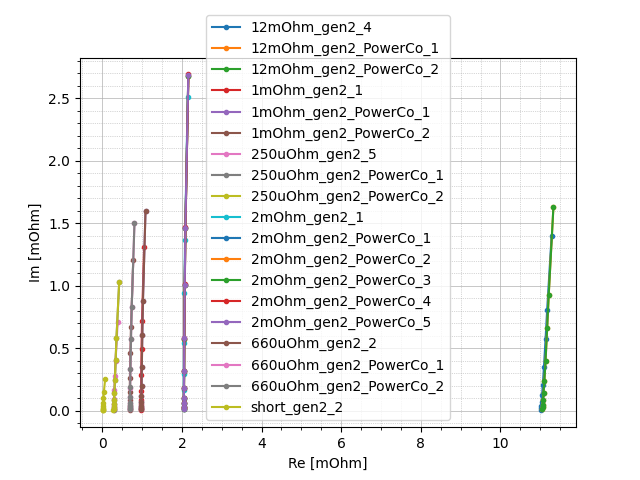

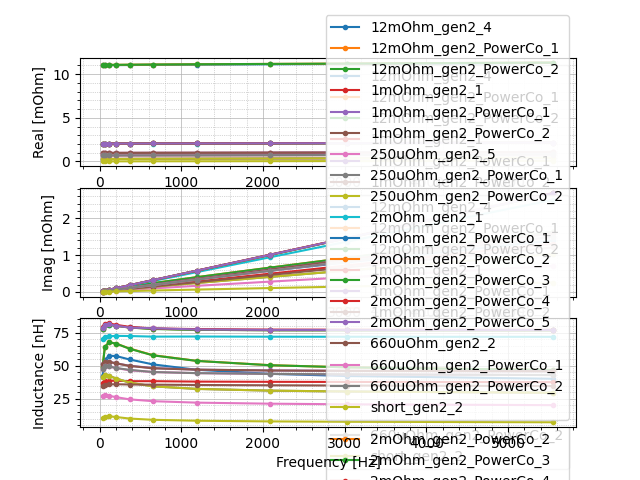

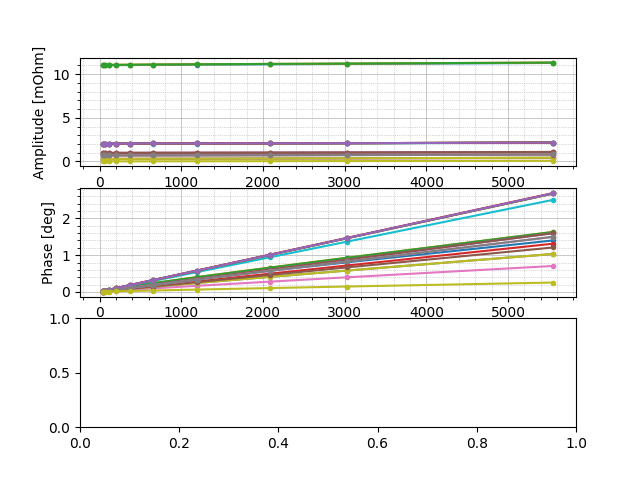

In [53]:
%matplotlib widget
impedance_dict = import_csv_folder(folder)

fig, ax = plt.subplots()
for impedance_name in impedance_dict:
    impedance_df = impedance_dict[impedance_name]
    plot_nyquist(ax, impedance_df, label=impedance_name, title='')

fig, ax = plt.subplots(3)
for impedance_name in impedance_dict:
    impedance_df = impedance_dict[impedance_name]
    plot_bode_re_imag(ax, impedance_df, label=impedance_name, title='')

fig, ax = plt.subplots(3)
for impedance_name in impedance_dict:
    impedance_df = impedance_dict[impedance_name]
    plot_bode(ax, impedance_df, label=impedance_name, title='')

### Corrected values

In [ ]:
%matplotlib widget
from copy import deepcopy

df_correct = pd.read_csv(correction_file)
impedance_dict = import_csv_folder(folder)

fig, ax = plt.subplots()
for impedance_name in impedance_dict:
    impedance_df = deepcopy(impedance_dict[impedance_name])

    impedance_df.Impedance_phase = 180/np.pi*np.unwrap(impedance_df.Impedance_phase*np.pi/180, period=np.pi*2, discont=np.pi/2)
    impedance_df.Impedance_phase = (impedance_df.Impedance_phase + 180) % 360 - 180

    impedance_df['Impedance_amplitude'] = impedance_df['Impedance_amplitude'] / (df_correct['Impedance_amplitude']/0.008)
    impedance_df['Impedance_phase']     = impedance_df['Impedance_phase'] - df_correct['Impedance_phase']

    impedance_df['Impedance_real'] = impedance_df.Impedance_amplitude * np.cos(impedance_df.Impedance_phase*np.pi/180)
    impedance_df['Impedance_imag'] = impedance_df.Impedance_amplitude * np.sin(impedance_df.Impedance_phase*np.pi/180)

    plot_nyquist(ax, impedance_df, label=impedance_name, title='')


# Applaying correction
#ref.data['Impedance_amplitude'] = ref.data['Impedance_amplitude'] / (df_correct['Impedance_amplitude']/0.008)
#ref.data['Impedance_phase']     = ref.data['Impedance_phase'] - df_correct['Impedance_phase']

In [ ]:
df_correct = pd.read_csv(correction_folder)

In [ ]:
df_correct

In [ ]:
impedance = impedance_dict['setup_zink_JLR_7']

impedance.Impedance_phase = 180/np.pi*np.unwrap(impedance.Impedance_phase*np.pi/180, period=np.pi*2, discont=np.pi/2)
impedance.Impedance_phase = (impedance.Impedance_phase + 180) % 360 - 180
    


In [ ]:
impedance['Impedance_amplitude'] = impedance['Impedance_amplitude'] / (df_correct['Impedance_amplitude']/0.008)
impedance['Impedance_phase']     = impedance['Impedance_phase'] - df_correct['Impedance_phase']

impedance['Impedance_real'] = impedance.Impedance_amplitude * np.cos(impedance.Impedance_phase*np.pi/180)
impedance['Impedance_imag'] = impedance.Impedance_amplitude * np.sin(impedance.Impedance_phase*np.pi/180)

In [ ]:
impedance_dict['setup_zink_JLR_7']

In [ ]:
impedance_dict['setup_zink_JLR_7'].to_csv('short_JLR_corr.csv')

In [ ]:
impedance_dict['1mOhm_zink_JLR_2']

In [ ]:
impedance_dict['1mOhm_zink_JLR_2'].to_csv('1mOhm_JLR_corr.csv')

# Testing

In [ ]:
import pyvisa
import numpy as np
import matplotlib.pyplot as plt

# Initialize VISA resource manager
rm = pyvisa.ResourceManager()

# Replace with your DAQ's VISA address
daq_resource = 'USB0::0x2A8D::0x5101::MY58021228::INSTR'
daq = rm.open_resource(daq_resource)
daq.timeout = 8000

# Query device ID to verify connection
device_id = daq.query("*IDN?")
print("Connected to:", device_id)

In [ ]:
daq.timeout = 8000

In [ ]:
sampl_rate = 50000

daq.write('ACQ3:VOLT 18V,DIFF,AC,TIME,1000,50000,(@101)')
daq.write('ACQ3:VOLT 18V,DIFF,AC,TIME,1000,50000,(@102)')

In [ ]:
daq.write('INIT3 (@101, 102)')

In [ ]:
print('CH1')
a1_str = daq.query('FETCh3? (@101)')
print('CH2')
a2_str = daq.query('FETCh3? (@102)')

In [ ]:
a1 = string_to_np_array(a1_str)
a1_i = np.arange(len(a1))/sampl_rate
a2 = string_to_np_array(a2_str)
a2_i = np.arange(len(a2))/sampl_rate



In [ ]:
params1 = fit_sine_wave(a1_i, a1)
params2 = fit_sine_wave(a2_i, a2)
print(params1)
print(params2)

In [ ]:
params1

In [ ]:
%matplotlib widget 

plt.figure(figsize=(10, 5))
plt.plot(a1_i, a1, label="a1")
#y_fit = params1[0] * np.sin(2 * np.pi * params1[2] * a1_i + params1[1])
#plt.plot(a1_i, y_fit, label="y_fit1")
plt.plot(a1_i, a2, label="a2")
#y_fit = params2[0] * np.sin(2 * np.pi * params2[2] * a2_i + params2[1])
#plt.plot(y_fit, label="y_fit2")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.title("DAQ Acquisition for a Single Frequency Point")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Sine function
def sine(t, A, f, phi, C):
    return A * np.sin(2 * np.pi * f * t + phi) + C

# Generate sample data (Optional)
t = np.linspace(0, 10, 1000)  # Time vector
y_true = 3 * np.sin(2 * np.pi * 0.5 * t + np.pi/4) + 1  # True signal
y_noisy = y_true + 0.5 * np.random.normal(size=len(t))  # Noisy signal

# Initial guess [Amplitude, Frequency, Phase, Offset]
p0 = [np.std(y_noisy), 0.5, 0, np.mean(y_noisy)]

# Fit curve
params, _ = curve_fit(sine, t, y_noisy, p0=p0)

# Unpack fitted parameters
A, f, phi, C = params
print(f"Amplitude: {A:.3f}, Frequency: {f:.3f}, Phase: {phi:.3f}, Offset: {C:.3f}")

# Plot
plt.figure(figsize=(10, 5))
plt.plot(t, y_noisy, label='Noisy Data', alpha=0.6)
plt.plot(t, sine(t, *params), 'r', label='Fitted Sine', linewidth=2)
plt.legend()
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Sine Wave Fitting')
plt.grid(True)
plt.show()
